In [4]:
from pyDOE import *
import matplotlib.pyplot as plt# Standard imports
import copy
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns 

# Fixing random state for reproducibility
np.random.seed(19680801)

In [5]:
import pickle as pkl

In [6]:
# Initialize the NASBench object which parses the raw data into memory (this
# should only be run once as it takes up to a few minutes).
from nasbench import api

path_to_nasbench_data_full ='/local_home/trao_ka/data/nasbench_full.tfrecord'
#path_to_nasbench_data_full = '/media/kalifou/SAMSUNG1/DLR_DAAD_Research_Backup/data/nasbench_full.tfrecord'

# Use nasbench_full.tfrecord for full dataset (run download command above).
nasbench = api.NASBench(path_to_nasbench_data_full)
#('/home/kalifou/Documents/dlr/data/nasbench_full.tfrecord')

/local_home/trao_ka/anaconda3/envs/nas_data_driven_init/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/local_home/trao_ka/anaconda3/envs/nas_data_driven_init/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/local_home/trao_ka/anaconda3/envs/nas_data_driven_init/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16"




Loading dataset from file... This may take a few minutes...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


/local_home/trao_ka/anaconda3/envs/nas_data_driven_init/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/local_home/trao_ka/anaconda3/envs/nas_data_driven_init/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/local_home/trao_ka/anaconda3/envs/nas_data_driven_init/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 

Loaded dataset in 161 seconds


In [7]:

# Useful constants
INPUT = 'input'
OUTPUT = 'output'
CONV3X3 = 'conv3x3-bn-relu'
CONV1X1 = 'conv1x1-bn-relu'
MAXPOOL3X3 = 'maxpool3x3'
NUM_VERTICES = 7
MAX_EDGES = 9
EDGE_SPOTS = NUM_VERTICES * (NUM_VERTICES - 1) / 2   # Upper triangular matrix
OP_SPOTS = NUM_VERTICES - 2   # Input/output vertices are fixed
ALLOWED_OPS = [CONV3X3, CONV1X1, MAXPOOL3X3]
ALLOWED_EDGES = [0, 1]   # Binary adjacency matrix

In [8]:
def sample_single_op(NUM_VERTICES, ALLOWED_OPS):
    x = lhs(NUM_VERTICES, samples=1)[0]
    vv = np.floor(x * len(ALLOWED_OPS))
    op  = [ALLOWED_OPS[int(k)] for k in vv]
    op[0] = INPUT
    op[-1] = OUTPUT
    return op

def sample_single_configurations_lhs(N_dimensions):    
    
    sum_edges = 0   
    while sum_edges != 9:
        v_m = lhs(N_dimensions, samples=1)
        idx = v_m > 0.5
        v_m[idx == True] = 1
        v_m[idx == False] = 0
        sum_edges = sum(v_m[0])
    
    return v_m[0]

def recover_incidence_matrix(a0, N_l=7):
    
    mat = np.zeros((N_l, N_l))
    idx_new = 0
    idx_old = 0
    
    for i in range(N_l):
        idx_new += N_l - i - 1
        
        values = a0[idx_old:idx_new]
        idx_old = idx_new
        mat[i, i+1: ] = values
        
    return mat

def sample_single_valid_spec(NUM_vert, allowed_ops):
    
    is_valid = False
    while not is_valid:
        current_op = sample_single_op(NUM_vert, allowed_ops)
        current_config = sample_single_configurations_lhs(N_dimensions = 7 * 3) 
        current_mat = recover_incidence_matrix(current_config, N_l=NUM_vert)
        current_spec = api.ModelSpec(matrix=current_mat, ops=current_op)        
        is_valid = nasbench.is_valid(current_spec)
        
    return current_mat, current_op, current_spec

def LHS_sample_N_valid_specs(N, NUM_vert, allowed_ops, nb):
 all_specs = []
 set_mats = set()
 while len(set_mats) < N:
   s = sample_single_valid_spec(NUM_vert, allowed_ops)
   m, o, sp = s
   t_m = tuple(m.reshape(NUM_vert * NUM_vert))
   hash_m = nb._hash_spec(sp)
   if hash_m not in set_mats:
     set_mats = set_mats | set([t_m])
     all_specs.append(s)

 return all_specs

In [9]:
def random_spec():
  """Returns a random valid spec."""
  while True:
    matrix = np.random.choice(ALLOWED_EDGES, size=(NUM_VERTICES, NUM_VERTICES))
    matrix = np.triu(matrix, 1)
    ops = np.random.choice(ALLOWED_OPS, size=(NUM_VERTICES)).tolist()
    ops[0] = INPUT
    ops[-1] = OUTPUT
    spec = api.ModelSpec(matrix=matrix, ops=ops)
    if nasbench.is_valid(spec):
      return matrix, ops, spec

# CLUSTERING

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from kneed import KneeLocator

from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, Birch
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import silhouette_score, adjusted_rand_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

In [12]:
MAX_NODES = 7
MAX_EDGES = 9
NASBENCH_TFRECORD = './data/nasbench_full.tfrecord'

INPUT = 'input'
OUTPUT = 'output'
CONV1X1 = 'conv1x1-bn-relu'
CONV3X3 = 'conv3x3-bn-relu'
MAXPOOL3X3 = 'maxpool3x3'

CODING = [INPUT]
CODING = CODING + [CONV1X1 + "_" + str(i) for i in range(0, (MAX_NODES - 2))]
CODING = CODING + [CONV3X3 + "_" + str(i) for i in range(0, (MAX_NODES - 2))]
CODING = CODING + [MAXPOOL3X3 + "_" + str(i) for i in range(0, (MAX_NODES - 2))]
CODING = CODING + [OUTPUT]

In [13]:
def rename_ops(ops):
    c1x1 = 0
    c3x3 = 0
    mp3x3 = 0
    new_ops = []
    for op in ops:
        if op == CONV1X1:
            new_ops = new_ops + [op + "_" + str(c1x1)]
            c1x1 = c1x1 + 1
        elif op == CONV3X3:
            new_ops = new_ops + [op + "_" + str(c3x3)]
            c3x3 = c3x3 + 1
        elif op == MAXPOOL3X3:
            new_ops = new_ops + [op + "_" + str(mp3x3)]
            mp3x3 = mp3x3 + 1
        else:
            new_ops = new_ops + [op]
    return new_ops



def encode_matrix_fixed_long(adj_matrix, ops):
    enc_matrix = np.zeros((len(CODING), len(CODING)))
    pos = [CODING.index(op) for op in ops]
    trans = dict()
    for i, ix in enumerate(pos):
        trans[i] = ix
    i, j = np.nonzero(adj_matrix)
    ix = [trans.get(n) for n in i]
    jy = [trans.get(n) for n in j]
    for p in zip(ix, jy):
        enc_matrix[p] = 1
    
    #print(enc_matrix)
    
    # Flattenning in C (row-major) ording
    encoded =  enc_matrix.flatten('C') 
    #enc_matrix[np.triu_indices(len(CODING), k=1)]
    return encoded.astype(int)


def rename_ops_fixed(ops):
    c1x1 = 0
    c3x3 = 0
    mp3x3 = 0
    new_ops = []
    for op in ops:
        if op == CONV1X1:
            new_ops = new_ops + [op + "_" + str(c1x1)]
            c1x1 = c1x1 + 1
        elif op == CONV3X3:
            new_ops = new_ops + [op + "_" + str(c3x3)]
            c3x3 = c3x3 + 1
        elif op == MAXPOOL3X3:
            new_ops = new_ops + [op + "_" + str(mp3x3)]
            mp3x3 = mp3x3 + 1
        else:
            new_ops = new_ops + [op]
    return new_ops

In [14]:
N_samples = 10000
extra_specs = list()
for iter in range(N_samples):
    spec = random_spec()
    extra_specs.append(spec)

In [15]:
models_and_perfs_all_epochs = list()

binary_and_perfs_all_epochs = list()

for m, o, cell in extra_specs:
    # Query an Inception-like cell from the dataset.
    cell = api.ModelSpec(
      matrix= m.astype(int),
      # Operations at the vertices of the module, matches order of matrix.
      ops= o) #[INPUT, CONV1X1, CONV3X3, CONV3X3, CONV3X3, MAXPOOL3X3, OUTPUT])
    local_perfs = []
    for N_epochs in [4, 12, 36, 108]:
        data = nasbench.query(cell, epochs=N_epochs)
        local_perfs.append(data['test_accuracy'])
    
    #################
    ### mat + perfs@4,12,36,108
    
    vectorized_ops = list()

    for item in o:
        if item == CONV3X3:
          vectorized_ops.append(4)  
        elif item == CONV1X1:
          vectorized_ops.append(5)  
        elif item == MAXPOOL3X3:
          vectorized_ops.append(6)  
        else:
            pass
    
    
    #print(local_perfs)
    feature_mat_and_perfs = list(m.flatten('C')) + vectorized_ops + local_perfs
    models_and_perfs_all_epochs.append(feature_mat_and_perfs)
    
    
    ops = rename_ops_fixed(o)
    binary_i = encode_matrix_fixed_long(m, ops)
    #print(binary_i)
    feature_binary_and_perfs = list(binary_i) + vectorized_ops + local_perfs
    binary_and_perfs_all_epochs.append(feature_binary_and_perfs)


# By Number of Components

In [16]:
feature_array = np.array(models_and_perfs_all_epochs)


scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_array)
feature_array.shape, 7*7+4

((10000, 58), 53)

In [17]:
feature_binary_array = np.array(binary_and_perfs_all_epochs)

scaler = StandardScaler()
scaled_features_binary = scaler.fit_transform(feature_binary_array)

feature_binary_array.shape, 17*17+4

((10000, 298), 293)

In [18]:
n_clusters = 10
n_components = 2

all_scores = dict()

all_scores['pca'] = dict()
all_scores['pca']['original'] = None
all_scores['pca']['binary'] = None

all_scores['truncated_svd'] = dict()
all_scores['truncated_svd']['original'] = None
all_scores['truncated_svd']['binary'] = None

# PCA

In [19]:
clusterer = Pipeline(
   [
       (
           "kmeans",
           KMeans(
               n_clusters=n_clusters,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=42,
           ),
       )
   ]
)

In [20]:
preprocessor = Pipeline(
    [
        #("scaler", MinMaxScaler()),
        ("pca", PCA(n_components=n_components, random_state=42)),
    ]
)

In [21]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

In [22]:
feature_array.shape

(10000, 58)

In [23]:
data = feature_array
# Empty lists to hold evaluation metrics
silhouette_scores = []
calinski_harabasz_scores = []

davies_bouldin_scores = []

n_components_max = 15

for n in range(2, n_components_max * 2, 2):
    # This set the number of components for pca,
    # but leaves other steps unchanged
    pipe["preprocessor"]["pca"].n_components = n
    pipe.fit(data)
    
    reduced_data = pipe["preprocessor"].transform(data)
    local_labels = pipe["clusterer"]["kmeans"].labels_
    
    silhouette_coef = silhouette_score(
        reduced_data,
        local_labels,
    )
    
    ch_score = calinski_harabasz_score(reduced_data, local_labels)
    
    db_score = davies_bouldin_score(reduced_data, local_labels)
    
    
    # Add metrics to their lists
    silhouette_scores.append(silhouette_coef)

    calinski_harabasz_scores.append(ch_score)
    
    davies_bouldin_scores.append(db_score)
y_scores = [silhouette_scores, calinski_harabasz_scores, davies_bouldin_scores]

all_scores['pca']['original'] = y_scores

In [24]:
data = feature_binary_array
# Empty lists to hold evaluation metrics
silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []

n_components_max = 15

for n in range(2, n_components_max * 2, 2):
    # This set the number of components |for pca,
    # but leaves other steps unchanged
    pipe["preprocessor"]["pca"].n_components = n
    pipe.fit(data)
    
    reduced_data = pipe["preprocessor"].transform(data)
    local_labels = pipe["clusterer"]["kmeans"].labels_
    
    silhouette_coef = silhouette_score(
        reduced_data,
        local_labels,
    )
    
    ch_score = calinski_harabasz_score(reduced_data, local_labels)
    
    db_score = davies_bouldin_score(reduced_data, local_labels)
    
    
    # Add metrics to their lists
    silhouette_scores.append(silhouette_coef)

    calinski_harabasz_scores.append(ch_score)
    
    davies_bouldin_scores.append(db_score)
y_scores = [silhouette_scores, calinski_harabasz_scores, davies_bouldin_scores]


all_scores['pca']['binary'] = y_scores

# Truncated SVD

In [25]:
clusterer = Pipeline(
   [
       (
           "kmeans",
           KMeans(
               n_clusters=n_clusters,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=42,
           ),
       )
   ]
)

In [26]:
preprocessor = Pipeline(
    [
        ("truncated_svd", TruncatedSVD(n_components=n_components, n_iter=7, 
                                       random_state=42)),
    ]
)

In [27]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

In [28]:
feature_array.shape

(10000, 58)

In [29]:
data = feature_array
# Empty lists to hold evaluation metrics
silhouette_scores = []
calinski_harabasz_scores = []

davies_bouldin_scores = []

n_components_max = 15

for n in range(2, n_components_max * 2, 2):
    # This set the number of components for pca,
    # but leaves other steps unchanged
    pipe["preprocessor"]["truncated_svd"].n_components = n
    pipe.fit(data)
    
    reduced_data = pipe["preprocessor"].transform(data)
    local_labels = pipe["clusterer"]["kmeans"].labels_
    
    silhouette_coef = silhouette_score(
        reduced_data,
        local_labels,
    )
    
    ch_score = calinski_harabasz_score(reduced_data, local_labels)
    
    db_score = davies_bouldin_score(reduced_data, local_labels)
    
    
    # Add metrics to their lists
    silhouette_scores.append(silhouette_coef)

    calinski_harabasz_scores.append(ch_score)
    
    davies_bouldin_scores.append(db_score)
y_scores = [silhouette_scores, calinski_harabasz_scores, davies_bouldin_scores]

all_scores['truncated_svd']['original'] = y_scores

In [30]:
data = feature_binary_array
# Empty lists to hold evaluation metrics
silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []

n_components_max = 15

for n in range(2, n_components_max * 2, 2):
    # This set the number of components |for pca,
    # but leaves other steps unchanged
    pipe["preprocessor"]["truncated_svd"].n_components = n
    pipe.fit(data)
    
    reduced_data = pipe["preprocessor"].transform(data)
    local_labels = pipe["clusterer"]["kmeans"].labels_
    
    silhouette_coef = silhouette_score(
        reduced_data,
        local_labels,
    )
    
    ch_score = calinski_harabasz_score(reduced_data, local_labels)
    
    db_score = davies_bouldin_score(reduced_data, local_labels)
    
    
    # Add metrics to their lists
    silhouette_scores.append(silhouette_coef)

    calinski_harabasz_scores.append(ch_score)
    
    davies_bouldin_scores.append(db_score)
y_scores = [silhouette_scores, calinski_harabasz_scores, davies_bouldin_scores]

all_scores['truncated_svd']['binary'] = y_scores

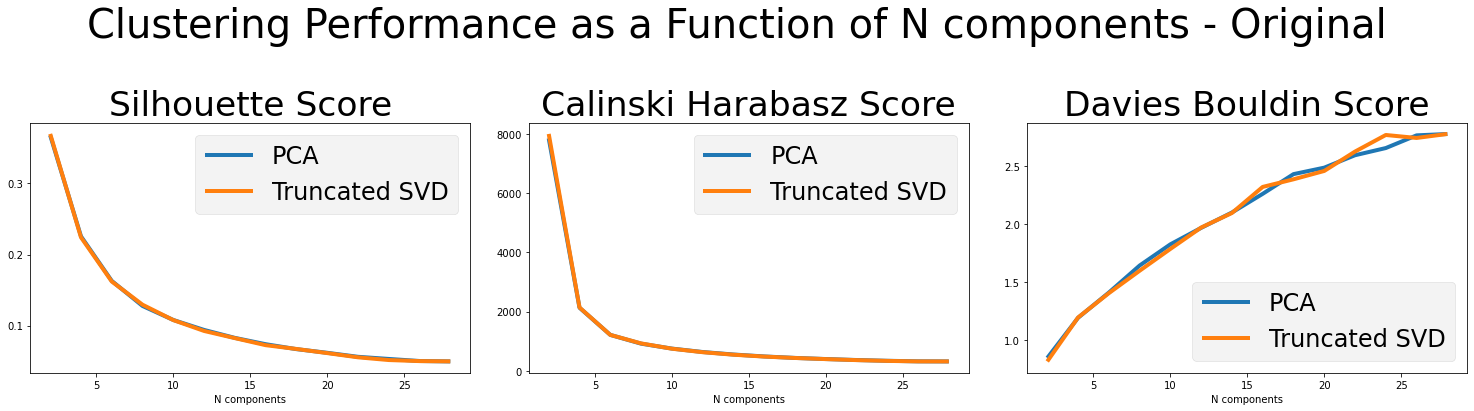

In [31]:
N_items = len(y_scores)

labels = ["Silhouette Score", "Calinski Harabasz Score", "Davies Bouldin Score"]

fig, axes = plt.subplots(nrows=1, ncols=N_items, figsize=(7 * N_items, 6))
plt.style.use("fivethirtyeight")
plt.rcParams.update({'font.size': 24})

for i in range(N_items):
    
    axes[i].plot(
    range(2, n_components_max * 2, 2),
    all_scores['pca']['original'][i], label='PCA')
    
    axes[i].plot(
    range(2, n_components_max * 2, 2),
    all_scores['truncated_svd']['original'][i], label='Truncated SVD')

    axes[i].set_title(labels[i])
    if "Davies" in labels[i]: 
        axes[i].legend(loc="lower right")
    else:
        axes[i].legend(loc="upper right")
    plt.setp(axes[i], xlabel="N components")

 
fig.suptitle("Clustering Performance as a Function of N components - Original", fontsize=40)
plt.tight_layout()
plt.show()

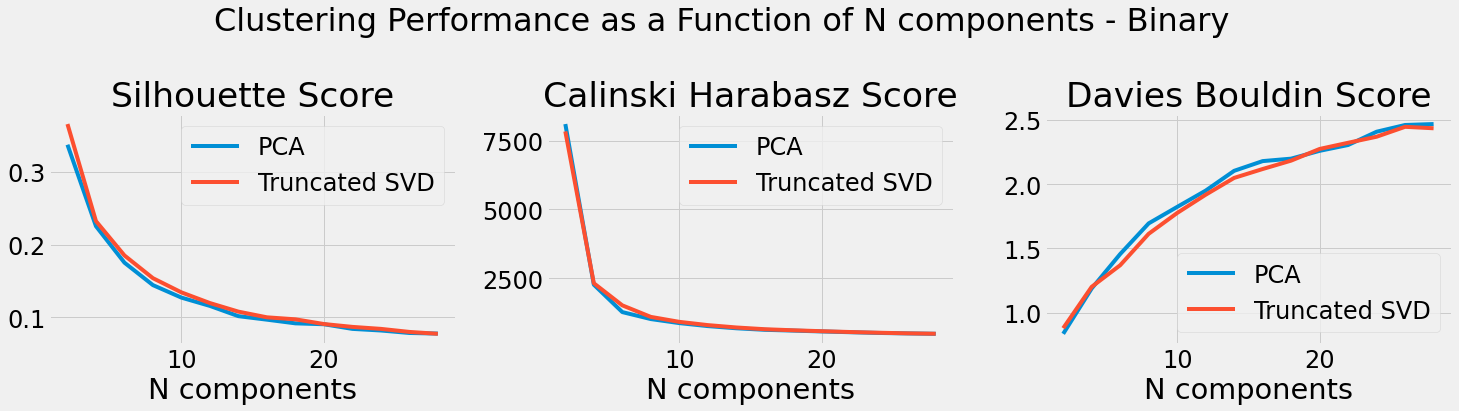

In [32]:
N_items = len(y_scores)
labels = ["Silhouette Score", "Calinski Harabasz Score", "Davies Bouldin Score"]

fig, axes = plt.subplots(nrows=1, ncols=N_items, figsize=(7 * N_items, 6))
plt.style.use("fivethirtyeight")
plt.rcParams.update({'font.size': 24})

for i in range(N_items):
    
    axes[i].plot(
    range(2, n_components_max * 2, 2),
    all_scores['pca']['binary'][i], label='PCA')
    
    axes[i].plot(
    range(2, n_components_max * 2, 2),
    all_scores['truncated_svd']['binary'][i], label='Truncated SVD')

    axes[i].set_title(labels[i])
    if "Davies" in labels[i]: 
        axes[i].legend(loc="lower right")
    else:
        axes[i].legend(loc="upper right")
    plt.setp(axes[i], xlabel="N components")

 
fig.suptitle("Clustering Performance as a Function of N components - Binary", fontsize=32)
plt.tight_layout()
plt.show()

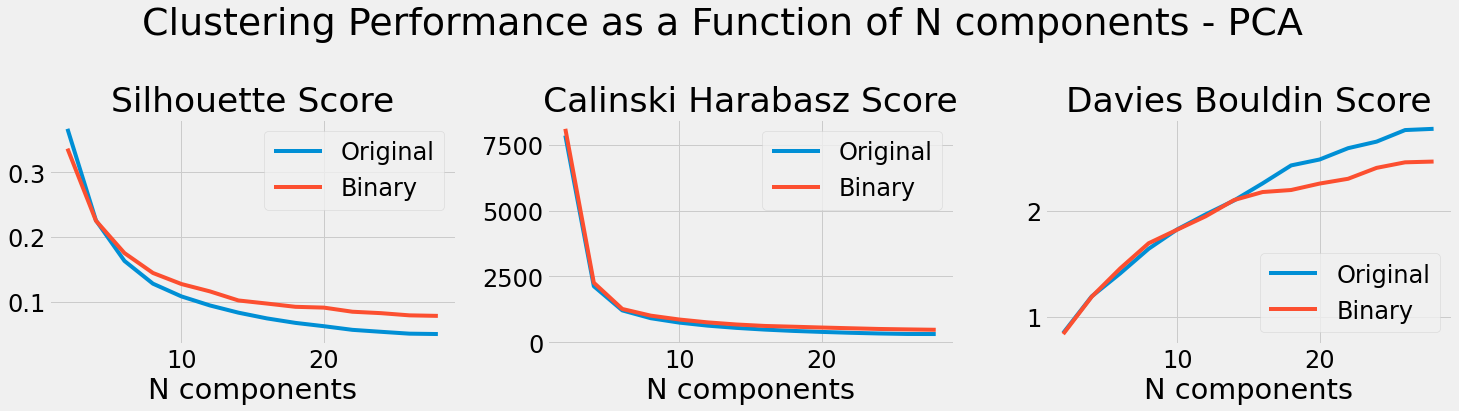

In [33]:
N_items = len(y_scores)
labels = ["Silhouette Score", "Calinski Harabasz Score", "Davies Bouldin Score"]

fig, axes = plt.subplots(nrows=1, ncols=N_items, figsize=(7 * N_items, 6))
plt.style.use("fivethirtyeight")
plt.rcParams.update({'font.size': 24})

for i in range(N_items):
    
    axes[i].plot(
    range(2, n_components_max * 2, 2),
    all_scores['pca']['original'][i], label='Original')
    
    axes[i].plot(
    range(2, n_components_max * 2, 2),
    all_scores['pca']['binary'][i], label='Binary')

    axes[i].set_title(labels[i])
    if "Davies" in labels[i]: 
        axes[i].legend(loc="lower right")
    else:
        axes[i].legend(loc="upper right")
    plt.setp(axes[i], xlabel="N components")

 
fig.suptitle("Clustering Performance as a Function of N components - PCA", fontsize=38)
plt.tight_layout()
plt.show()

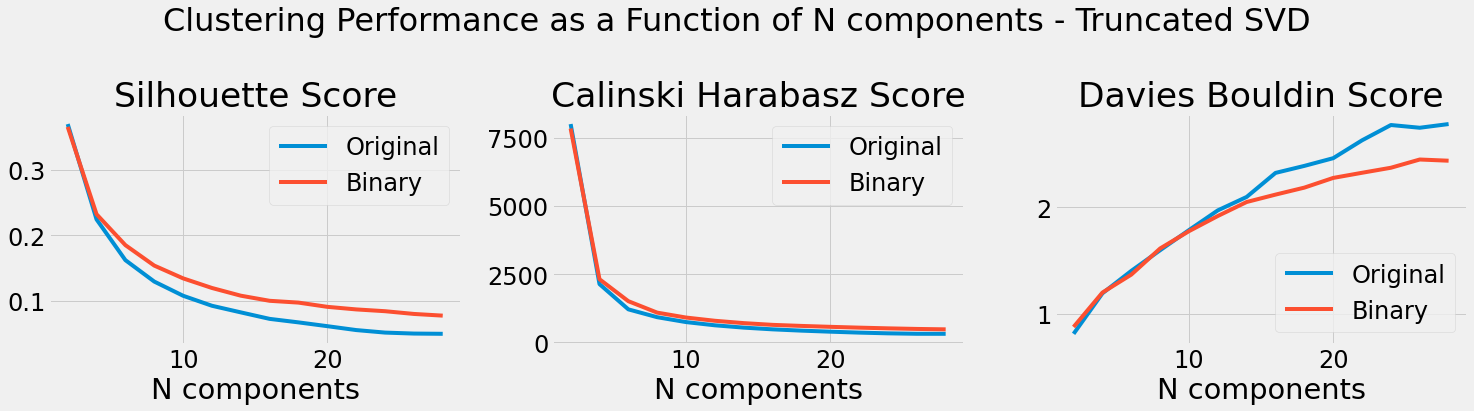

In [34]:
N_items = len(y_scores)
labels = ["Silhouette Score", "Calinski Harabasz Score", "Davies Bouldin Score"]

fig, axes = plt.subplots(nrows=1, ncols=N_items, figsize=(7 * N_items, 6))
plt.style.use("fivethirtyeight")
plt.rcParams.update({'font.size': 24})

for i in range(N_items):
    
    axes[i].plot(
    range(2, n_components_max * 2, 2),
    all_scores['truncated_svd']['original'][i], label='Original')
    
    axes[i].plot(
    range(2, n_components_max * 2, 2),
    all_scores['truncated_svd']['binary'][i], label='Binary')

    axes[i].set_title(labels[i])
    if "Davies" in labels[i]: 
        axes[i].legend(loc="lower right")
    else:
        axes[i].legend(loc="upper right")
    plt.setp(axes[i], xlabel="N components")

 
fig.suptitle("Clustering Performance as a Function of N components - Truncated SVD", fontsize=32)
plt.tight_layout()
plt.show()

# By Number of Clusters

In [35]:
Max_N_clusters = 45
step = 3
n_components = 2

In [36]:
clusterer = Pipeline(
   [
       (
           "kmeans",
           KMeans(
               n_clusters=2,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=42,
           ),
       )
   ]
)

In [37]:
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 50,
    "max_iter": 500,
    "random_state": 42,
}

In [38]:
preprocessor = Pipeline(
    [
        ("truncated_svd", TruncatedSVD(n_components=n_components, n_iter=7, 
                                       random_state=42)),
    ]
)

In [39]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

In [40]:
all_scores_by_n_clusters = []

In [41]:
data = feature_array

# Empty lists to hold evaluation metrics
silhouette_scores = []

calinski_harabasz_scores = []

davies_bouldin_scores = []

sse_scores = []

for k in range(2, Max_N_clusters, step):
    #kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    #kmeans.fit(feature_array)
    
    

    pipe["clusterer"]["kmeans"].n_clusters = k
    pipe["preprocessor"]["truncated_svd"].n_components = 2
    
    pipe.fit(data)
    
    reduced_data = pipe["preprocessor"].transform(data)
    local_labels = pipe["clusterer"]["kmeans"].labels_
    
    silhouette_coef = silhouette_score(
        reduced_data,
        local_labels,
    )
    
    ch_score = calinski_harabasz_score(reduced_data, local_labels)
    
    db_score = davies_bouldin_score(reduced_data, local_labels)
    
    
    # Add metrics to their lists
    silhouette_scores.append(silhouette_coef)

    calinski_harabasz_scores.append(ch_score)
    
    davies_bouldin_scores.append(db_score)
    
    sse_scores.append(pipe["clusterer"]["kmeans"].inertia_)
    
        
y_scores_n_clusters = [silhouette_scores, calinski_harabasz_scores, davies_bouldin_scores, sse_scores]

all_scores_by_n_clusters.append(y_scores_n_clusters)

In [42]:
kl = KneeLocator(
    range(2, Max_N_clusters, step), sse_scores, curve="convex", direction="decreasing"
)

kl.elbow

11

# Using A binary Encoding

In [43]:
data = feature_binary_array

# Empty lists to hold evaluation metrics
silhouette_scores = []

calinski_harabasz_scores = []

davies_bouldin_scores = []

sse_scores = []

for k in range(2, Max_N_clusters, step):
    
    

    pipe["clusterer"]["kmeans"].n_clusters = k
    pipe["preprocessor"]["truncated_svd"].n_components = 2
    
    pipe.fit(data)
    
    reduced_data = pipe["preprocessor"].transform(data)
    local_labels = pipe["clusterer"]["kmeans"].labels_
    
    silhouette_coef = silhouette_score(
        reduced_data,
        local_labels,
    )
    
    ch_score = calinski_harabasz_score(reduced_data, local_labels)
    
    db_score = davies_bouldin_score(reduced_data, local_labels)
    
    
    # Add metrics to their lists
    silhouette_scores.append(silhouette_coef)

    calinski_harabasz_scores.append(ch_score)
    
    davies_bouldin_scores.append(db_score)
    
    sse_scores.append(pipe["clusterer"]["kmeans"].inertia_)
    
        
y_scores_n_clusters = [silhouette_scores, calinski_harabasz_scores, davies_bouldin_scores] #, sse_scores]

all_scores_by_n_clusters.append(y_scores_n_clusters)

In [44]:
kl = KneeLocator(
    range(2, Max_N_clusters, step), sse_scores, curve="convex", direction="decreasing"
)

kl.elbow

11

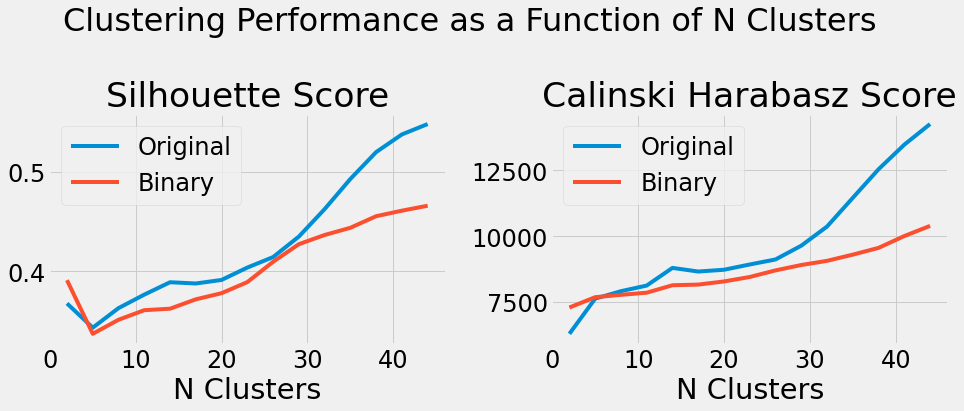

In [45]:

labels = ["Silhouette Score", "Calinski Harabasz Score", "Davies Bouldin Score"] #, "SSE"]
N_items = len(y_scores_n_clusters[:-1])

fig, axes = plt.subplots(nrows=1, ncols=N_items, figsize=(7 * N_items, 6))
plt.rcParams.update({'font.size': 24})

for i in range(N_items):
    
    axes[i].plot(
    range(2, Max_N_clusters, step),
    all_scores_by_n_clusters[0][i], label='Original')
    
    axes[i].plot(
    range(2, Max_N_clusters, step),
    all_scores_by_n_clusters[1][i], label='Binary')

    axes[i].set_title(labels[i])
    if "Davies" in labels[i]: 
        axes[i].legend(loc="upper right")
    else:
        axes[i].legend(loc="upper left")
    plt.setp(axes[i], xlabel="N Clusters")

#axes[i].set_title("SSE - Knee @ " + str(kl.elbow))    
 
fig.suptitle("Clustering Performance as a Function of N Clusters", fontsize=32)
plt.tight_layout()
plt.show()

# Distance Metrics

In [46]:
Max_N_clusters = 10
step = 3
n_components = 2

In [47]:
clusterer = Pipeline(
   [
       (
           "kmeans",
           KMeans(
               n_clusters=2,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=42,
           ),
       )
   ]
)

In [48]:
preprocessor = Pipeline(
    [
        ("truncated_svd", TruncatedSVD(n_components=n_components, n_iter=7, 
                                       random_state=42)),
    ]
)

In [49]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

In [50]:
all_scores_by_n_clusters = []

In [51]:
data = feature_array

# Empty lists to hold evaluation metrics
silhouette_scores = []

calinski_harabasz_scores = []

davies_bouldin_scores = []

sse_scores = []

for k in range(2, Max_N_clusters, step):    
    

    pipe["clusterer"]["kmeans"].n_clusters = k
    #pipe["clusterer"]["kmeans"].affinity = 'euclidian'
    pipe["preprocessor"]["truncated_svd"].n_components = 2
    
    pipe.fit(data)
    
    reduced_data = pipe["preprocessor"].transform(data)
    local_labels = pipe["clusterer"]["kmeans"].labels_
    
    silhouette_coef = silhouette_score(
        reduced_data,
        local_labels,
    )
    
    ch_score = calinski_harabasz_score(reduced_data, local_labels)
    
    db_score = davies_bouldin_score(reduced_data, local_labels)
    
    
    # Add metrics to their lists
    silhouette_scores.append(silhouette_coef)

    calinski_harabasz_scores.append(ch_score)
    
    davies_bouldin_scores.append(db_score)
    
    sse_scores.append(pipe["clusterer"]["kmeans"].inertia_)
    
        
y_scores_n_clusters = [silhouette_scores, calinski_harabasz_scores, davies_bouldin_scores, sse_scores]

all_scores_by_n_clusters.append(y_scores_n_clusters)

In [52]:
data = feature_array

# Empty lists to hold evaluation metrics
silhouette_scores = []

calinski_harabasz_scores = []

davies_bouldin_scores = []

sse_scores = []

for k in range(2, Max_N_clusters, step):    
    

    pipe["clusterer"]["kmeans"].n_clusters = k
    pipe["clusterer"]["kmeans"].metric = 'cosine'
    pipe["preprocessor"]["truncated_svd"].n_components = 2
    
    pipe.fit(data)
    
    reduced_data = pipe["preprocessor"].transform(data)
    local_labels = pipe["clusterer"]["kmeans"].labels_
    
    silhouette_coef = silhouette_score(
        reduced_data,
        local_labels,
    )
    
    ch_score = calinski_harabasz_score(reduced_data, local_labels)
    
    db_score = davies_bouldin_score(reduced_data, local_labels)
    
    
    # Add metrics to their lists
    silhouette_scores.append(silhouette_coef)

    calinski_harabasz_scores.append(ch_score)
    
    davies_bouldin_scores.append(db_score)
    
    sse_scores.append(pipe["clusterer"]["kmeans"].inertia_)
    
        
y_scores_n_clusters = [silhouette_scores, calinski_harabasz_scores, davies_bouldin_scores, sse_scores]

all_scores_by_n_clusters.append(y_scores_n_clusters)

In [53]:
kl = KneeLocator(
    range(2, Max_N_clusters, step), sse_scores, curve="convex", direction="decreasing"
)

kl.elbow

/local_home/trao_ka/anaconda3/envs/nas_data_driven_init/lib/python3.7/site-packages/kneed/knee_locator.py:304: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")


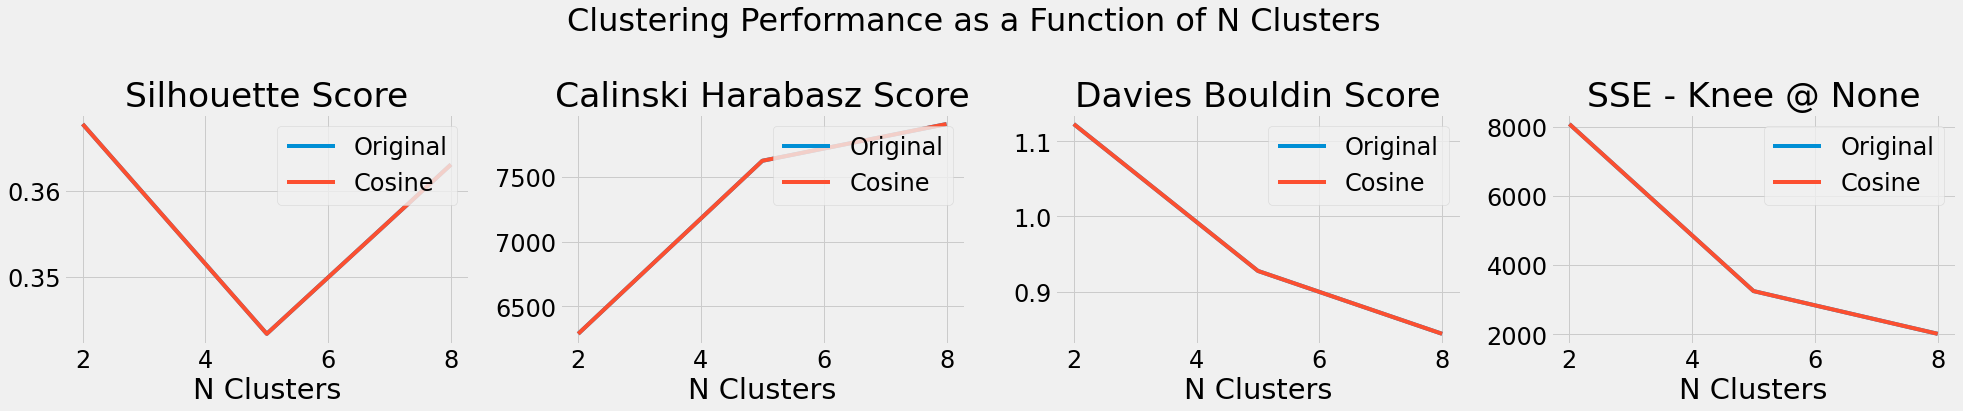

In [54]:

labels = ["Silhouette Score", "Calinski Harabasz Score", "Davies Bouldin Score", "SSE"]
N_items = len(y_scores_n_clusters)

fig, axes = plt.subplots(nrows=1, ncols=N_items, figsize=(7 * N_items, 6))


for i in range(N_items):
    
    axes[i].plot(
    range(2, Max_N_clusters, step),
    all_scores_by_n_clusters[0][i], label='Original')
    
    axes[i].plot(
    range(2, Max_N_clusters, step),
    all_scores_by_n_clusters[1][i], label='Cosine')

    axes[i].set_title(labels[i])
    axes[i].legend(loc="upper right")
    plt.setp(axes[i], xlabel="N Clusters")

axes[i].set_title("SSE - Knee @ " + str(kl.elbow))    
 
fig.suptitle("Clustering Performance as a Function of N Clusters", fontsize=32)
plt.tight_layout()
plt.show()

# Qualitative Analysis

## Using the Original Encoding

In [55]:
n_clusters = 27
n_components = 2

In [56]:
Algos = [(
           "KMEANS",
           KMeans(
               n_clusters=n_clusters,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=42,
           ),
       ),
       
       (
           "SPECTRAL",
           SpectralClustering(n_clusters=n_clusters,
               random_state=42),
       ),
       
       (
           "DBSCAN",
           DBSCAN(eps=0.30, min_samples=200),
       ),
        (
           "BIRCH",
           Birch(n_clusters=n_clusters, threshold=0.12),
       ),
        (
           "BGM",
           BayesianGaussianMixture(n_components=n_clusters, covariance_type='full',
           random_state=42,
           weight_concentration_prior_type="dirichlet_distribution",
           max_iter=500,
                                  )
       ),    
    
]

In [57]:
algo_labels = ["KMEANS", "SPECTRAL", "DBSCAN", "BIRCH", "BGM"]

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


(27, 2) 18


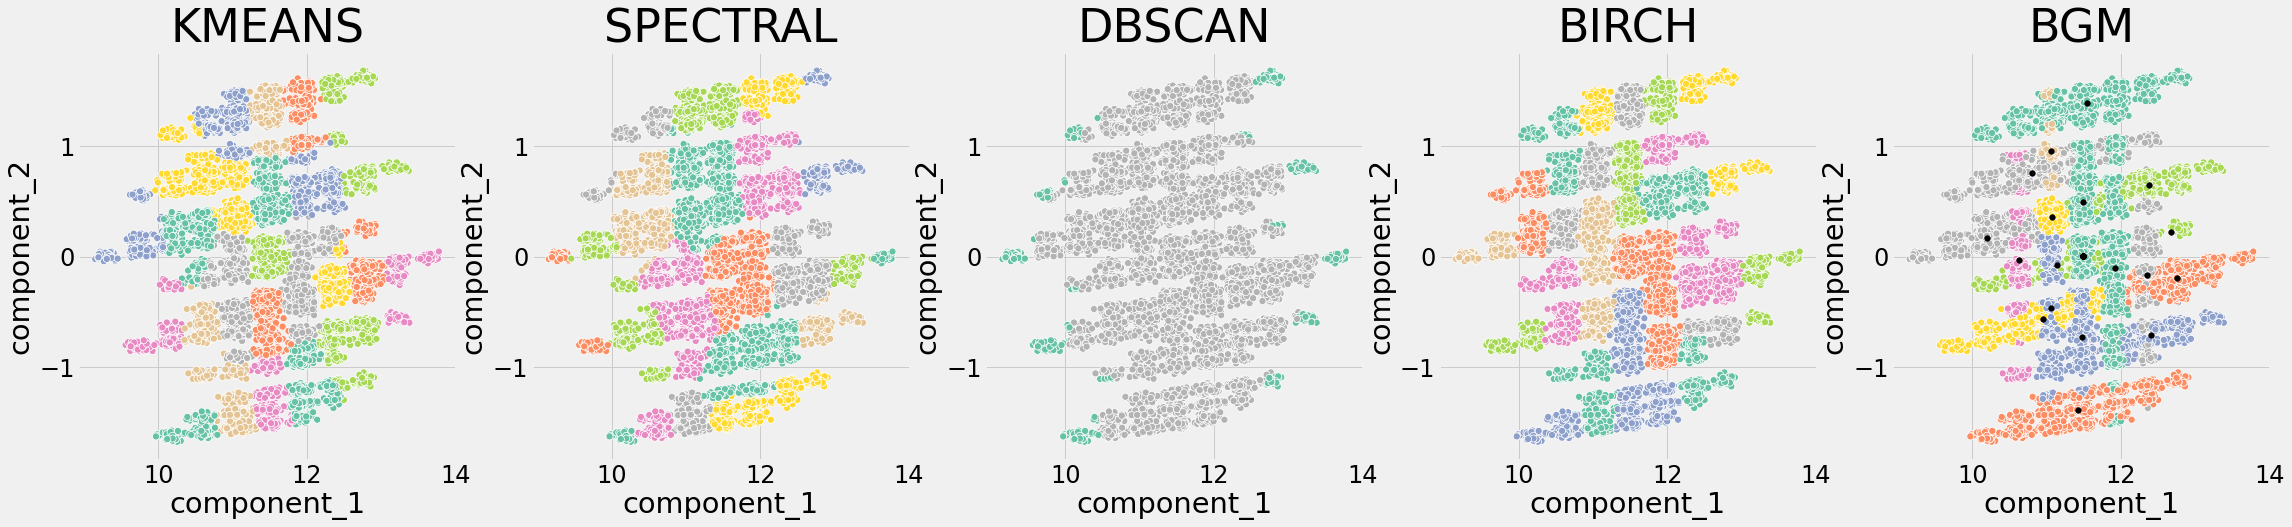

In [58]:
n_plots = len(algo_labels)

fig, axes = plt.subplots(nrows=1, ncols=n_plots, figsize=(7 * n_plots, 7))
plt.style.use("fivethirtyeight")
plt.rcParams.update({'font.size': 32})

for i_algo, algo in enumerate(Algos):

    preprocessor = Pipeline(
        [
            ("truncated_svd", TruncatedSVD(n_components=n_components, n_iter=7, 
                                           random_state=42)),    ]
    )


    clusterer = Pipeline(
       [
           algo
       ]
    )


    pipe = Pipeline(
        [
            ("preprocessor", preprocessor),
            ("clusterer", clusterer)
        ]
    )

    data = feature_array
    pipe.fit(data)


    pcadf = pd.DataFrame(
        pipe["preprocessor"].transform(data),
        columns=["component_1", "component_2"],
    )
    
    predicted_labels = None
    
    if "BGM" in algo_labels[i_algo]:
        predicted_labels =  pipe["clusterer"][algo_labels[i_algo]].predict(pipe["preprocessor"].transform(data))
    else:
        predicted_labels = pipe["clusterer"][algo_labels[i_algo]].labels_
        
    pcadf["predicted_cluster"] = predicted_labels

    
   

    scat = sns.scatterplot(
        "component_1",
        "component_2",
        s=50,
        data=pcadf,
        hue="predicted_cluster",
        palette="Set2", ax=axes[i_algo],
    )

    scat.set_title(
        algo_labels[i_algo]
    )

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    axes[i_algo].get_legend().set_visible(False)
    
    
    
    if "BGM" in algo_labels[i_algo]:
        
        import scipy
        
        gmm = pipe["clusterer"][algo_labels[i_algo]]
        X = pipe["preprocessor"].transform(data)
        
        centers = np.empty(shape=(gmm.n_components, X.shape[1]))
        
        for i in range(gmm.n_components):
            density = scipy.stats.multivariate_normal(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(X)
            centers[i, :] = X[np.argmax(density)]
        plt.scatter(centers[:, 0], centers[:, 1], s=32, c="k")
        
        print(centers.shape, len(set(predicted_labels)))
    
    
plt.show()

# Binary Encoding

In [59]:
n_clusters = 20
n_components = 2





No handles with labels found to put in legend.


KMEANS (27, 2)


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


(27, 2) 15


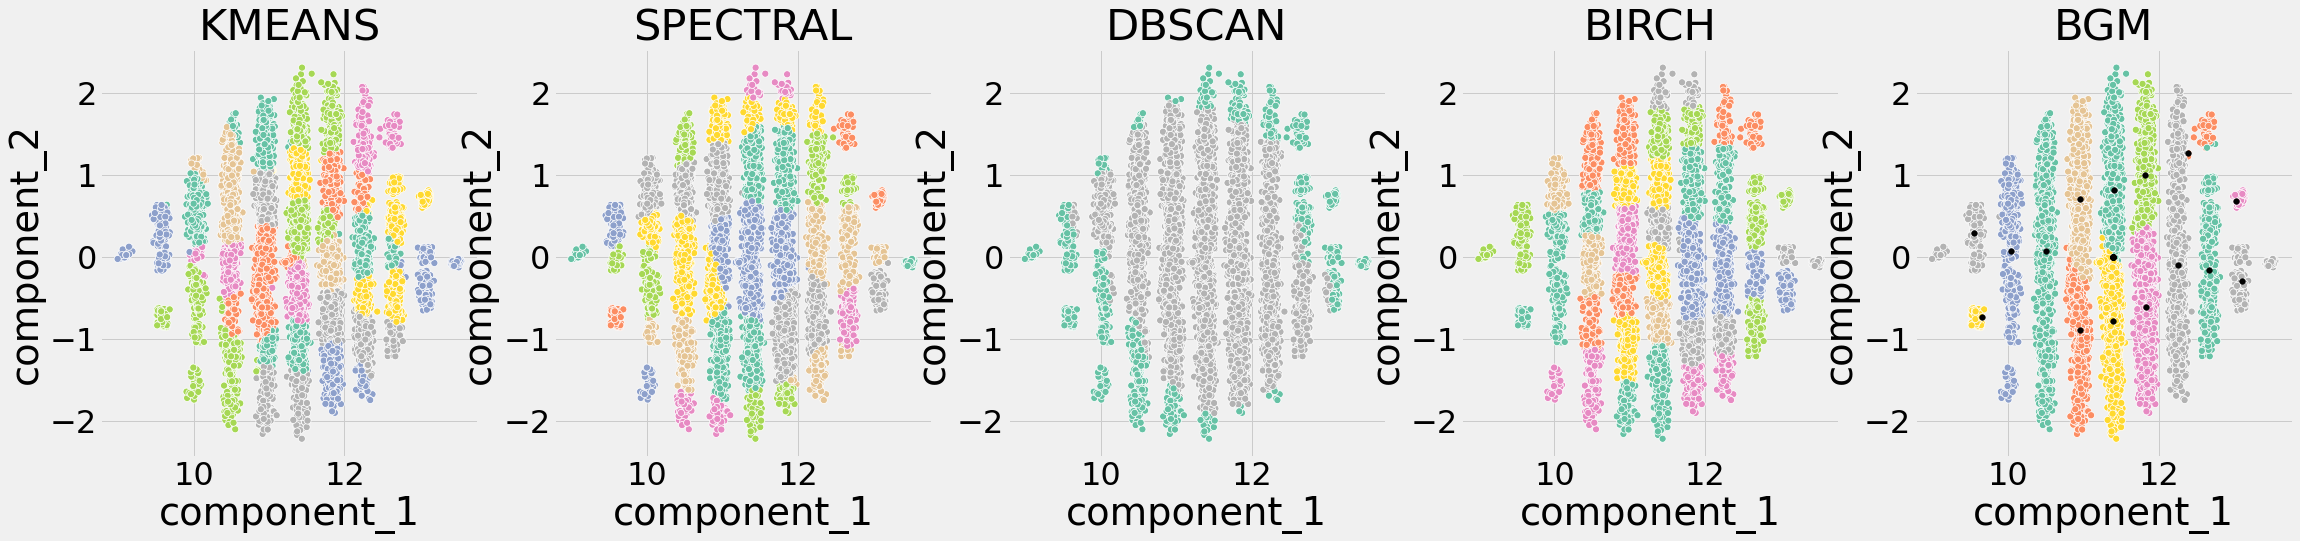

In [60]:
n_plots = len(algo_labels)
fig, axes = plt.subplots(nrows=1, ncols=n_plots, figsize=(7 * n_plots, 7))
plt.style.use("fivethirtyeight")
plt.rcParams.update({'font.size': 30})

for i_algo, algo in enumerate(Algos):

    preprocessor = Pipeline(
        [
            ("truncated_svd", TruncatedSVD(n_components=n_components, n_iter=7, 
                                           random_state=42)),    ]
    )


    clusterer = Pipeline(
       [
           algo
       ]
    )


    pipe = Pipeline(
        [
            ("preprocessor", preprocessor),
            ("clusterer", clusterer)
        ]
    )

    data = feature_binary_array
    pipe.fit(data)


    pcadf = pd.DataFrame(
        pipe["preprocessor"].transform(data),
        columns=["component_1", "component_2"],
    )

    predicted_labels = None
    
    if "BGM" in algo_labels[i_algo]:
        predicted_labels =  pipe["clusterer"][algo_labels[i_algo]].predict(pipe["preprocessor"].transform(data))
    else:
        predicted_labels = pipe["clusterer"][algo_labels[i_algo]].labels_
        
    pcadf["predicted_cluster"] = predicted_labels

    #import ipdb
    #ipdb.set_trace()
    
    scat = sns.scatterplot(
        "component_1",
        "component_2",
        s=50,
        data=pcadf,
        hue="predicted_cluster",
        palette="Set2", ax=axes[i_algo], #Paired
    )

    scat.set_title(
        algo_labels[i_algo]
    )

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    axes[i_algo].get_legend().set_visible(False)
    
    
    #import ipdb
    #ipdb.set_trace()
    if algo_labels[i_algo] in ["KMEANS"]:
        print(algo_labels[i_algo], pipe["clusterer"][algo_labels[i_algo]].cluster_centers_.shape)
    
    elif "BGM" in algo_labels[i_algo]:
        
        import scipy
        
        gmm = pipe["clusterer"][algo_labels[i_algo]]
        X = pipe["preprocessor"].transform(data)
        
        centers = np.empty(shape=(gmm.n_components, X.shape[1]))
        
        for i in range(gmm.n_components):
            density = scipy.stats.multivariate_normal(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(X)
            centers[i, :] = X[np.argmax(density)]
        plt.scatter(centers[:, 0], centers[:, 1], s=32, c="k")
        
        print(centers.shape, len(set(predicted_labels)))
    else:
        pass #"SPECTRAL", "DBSCAN", "BIRCH"]:
plt.show()


# Extracting Centroids & Configurations

In [61]:
list_indices_centroids = None

## Using the Original Encoding

In [62]:
n_clusters = 27
n_components = 2

(27, 2) 18


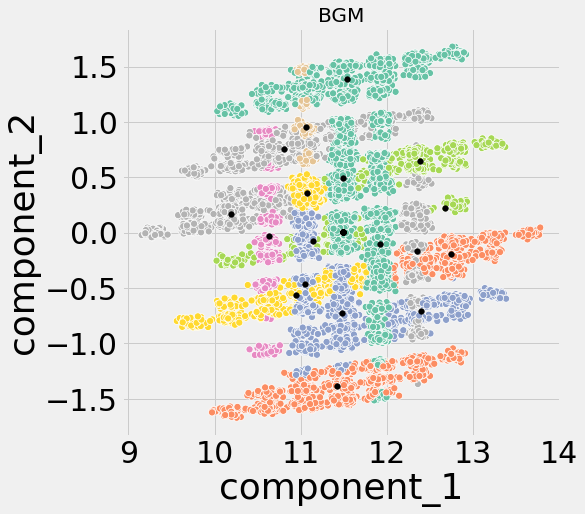

In [63]:
plt.close()
import scipy


preprocessor = Pipeline(
    [
        ("truncated_svd", TruncatedSVD(n_components=n_components, n_iter=7, 
                                       random_state=42)),    ]
)


clusterer = Pipeline(
   [
       algo
   ]
)


pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

data = feature_array
pipe.fit(data)

fig, axes = plt.subplots(figsize=(7,7))
plt.style.use("fivethirtyeight")

pcadf = pd.DataFrame(
pipe["preprocessor"].transform(data),
columns=["component_1", "component_2"],
)


predicted_labels =  pipe["clusterer"]["BGM"].predict(pipe["preprocessor"].transform(data))

pcadf["predicted_cluster"] = predicted_labels

#import ipdb
#ipdb.set_trace()

scat = sns.scatterplot(
    "component_1",
    "component_2",
    s=50,
    data=pcadf,
    hue="predicted_cluster",
    palette="Set2", ax=axes, #Paired
)

scat.set_title(
    algo_labels[i_algo]
)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
axes.get_legend().set_visible(False)

gmm = pipe["clusterer"]["BGM"]
X = pipe["preprocessor"].transform(data)

centers = np.empty(shape=(gmm.n_components, X.shape[1]))

for i in range(gmm.n_components):
    density = scipy.stats.multivariate_normal(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(X)
    centers[i, :] = X[np.argmax(density)]
    
    location_i = np.where(X == centers[i])[0][0]
    #print(centers[i], X[location_i])
    
    
plt.scatter(centers[:, 0], centers[:, 1], s=32, c="k")



#index_closest
print(centers.shape, len(set(predicted_labels)))
plt.show()

In [64]:
data.shape

(10000, 58)

In [65]:
list_indices_centroids_original = list()

for i in range(gmm.n_components):
    density = scipy.stats.multivariate_normal(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(X)
    centers[i, :] = X[np.argmax(density)]
    
    location_i = np.where(X == centers[i])[0][0]
    list_indices_centroids_original.append(location_i)

centroids_data = data[list_indices_centroids_original]

In [66]:
#centroids_data[:, -5:]

centroid_idx_i = list_indices_centroids_original[1]
are_identical = list()

for centroid_idx_i in list_indices_centroids_original:
    centroid_specs_0 = extra_specs[centroid_idx_i]

    m0, ops0, _ = centroid_specs_0
    len_0 = m0.flatten('C').shape[0]
    bool_check = np.all(m0.flatten('C') == feature_array[centroid_idx_i][:len_0].astype(int)) #, len_0
    
    are_identical.append(bool_check)
    
are_identical, len(are_identical)

([True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True],
 27)

## Using the Binary Encoding

In [67]:
n_clusters = 20
n_components = 2

In [68]:
algo = (
           "BGM",
           BayesianGaussianMixture(n_components=n_clusters, covariance_type='full',
           random_state=42,
           weight_concentration_prior_type="dirichlet_distribution",
           max_iter=500,
                                  )
       )

(20, 2) 12


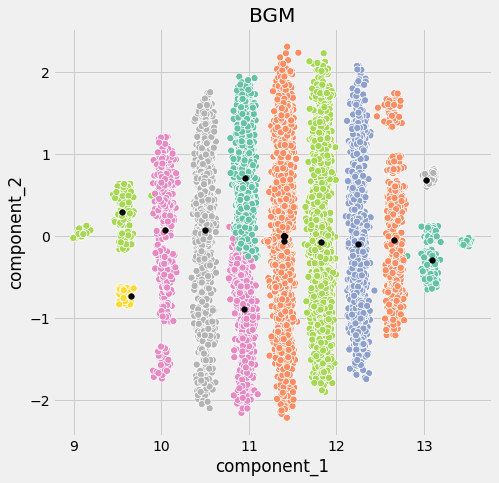

In [69]:
import scipy
plt.close()

preprocessor = Pipeline(
    [
        ("truncated_svd", TruncatedSVD(n_components=n_components, n_iter=7, 
                                       random_state=42)),    ]
)


clusterer = Pipeline(
   [
       algo
   ]
)


pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

data = feature_binary_array
pipe.fit(data)

fig, axes = plt.subplots(figsize=(7,7))
plt.style.use("fivethirtyeight")


pcadf = pd.DataFrame(
pipe["preprocessor"].transform(data),
columns=["component_1", "component_2"],
)


predicted_labels =  pipe["clusterer"]["BGM"].predict(pipe["preprocessor"].transform(data))

pcadf["predicted_cluster"] = predicted_labels

#import ipdb
#ipdb.set_trace()

scat = sns.scatterplot(
    "component_1",
    "component_2",
    s=50,
    data=pcadf,
    hue="predicted_cluster",
    palette="Set2", ax=axes, #Paired
)

scat.set_title(
    algo_labels[i_algo]
)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
axes.get_legend().set_visible(False)

gmm = pipe["clusterer"]["BGM"]
X = pipe["preprocessor"].transform(data)

centers = np.empty(shape=(gmm.n_components, X.shape[1]))

for i in range(gmm.n_components):
    density = scipy.stats.multivariate_normal(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(X)
    centers[i, :] = X[np.argmax(density)]
    
    location_i = np.where(X == centers[i])[0][0]
    #print(centers[i], X[location_i])
    
    
plt.scatter(centers[:, 0], centers[:, 1], s=32, c="k")



#index_closest
print(centers.shape, len(set(predicted_labels)))

plt.show()

In [70]:
list_indices_centroids_binary = list()

for i in range(gmm.n_components):
    density = scipy.stats.multivariate_normal(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(X)
    centers[i, :] = X[np.argmax(density)]
    
    location_i = np.where(X == centers[i])[0][0]
    list_indices_centroids_binary.append(location_i)

centroids_data = data[list_indices_centroids_binary]

In [71]:
#centroids_data[:, -5:]

centroid_idx_i = list_indices_centroids_binary[1]
are_identical = list()

for centroid_idx_i in list_indices_centroids_binary:
    centroid_specs_0 = extra_specs[centroid_idx_i]

    m0, ops0, _ = centroid_specs_0
    len_0 = m0.flatten('C').shape[0]
    bool_check = np.all(m0.flatten('C') == feature_array[centroid_idx_i][:len_0].astype(int)) #, len_0
    
    are_identical.append(bool_check)
    
are_identical, len(are_identical)

([True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True],
 20)

### Configuration of it

### Using those models to init a GA

In [72]:
dict_centroids = dict()
for c_i in list_indices_centroids_original:
    dict_centroids[int(c_i)] = [extra_specs[c_i][0].tolist(), extra_specs[c_i][1]]

    
import json

#with open('centroids_N27.json', 'w') as fp:
#    json.dump(dict_centroids, fp)
        

In [73]:
len(dict_centroids)

19

In [74]:
dict_centroids_binary = dict()
for c_i in list_indices_centroids_binary:
    dict_centroids_binary[int(c_i)] = [extra_specs[c_i][0].tolist(), extra_specs[c_i][1]]

    
import json

with open('centroids_N13_binary.json', 'w') as fp:
    json.dump(dict_centroids_binary, fp)
        

In [75]:
len(dict_centroids_binary), len(set(list_indices_centroids_binary)), 10

(13, 13, 10)

In [76]:
len(list_indices_centroids_original), len(set(list_indices_centroids_original)), list_indices_centroids_original

(27,
 19,
 [3457,
  192,
  1985,
  6194,
  8612,
  1985,
  9663,
  4764,
  6454,
  4151,
  7591,
  1985,
  1985,
  9393,
  4791,
  5006,
  1985,
  3621,
  1985,
  2497,
  1985,
  3389,
  1985,
  4765,
  6995,
  1985,
  7431])

In [77]:
def random_spec():
  """Returns a random valid spec."""
  while True:
    matrix = np.random.choice(ALLOWED_EDGES, size=(NUM_VERTICES, NUM_VERTICES))
    matrix = np.triu(matrix, 1)
    ops = np.random.choice(ALLOWED_OPS, size=(NUM_VERTICES)).tolist()
    ops[0] = INPUT
    ops[-1] = OUTPUT
    spec = api.ModelSpec(matrix=matrix, ops=ops)
    if nasbench.is_valid(spec):
      return spec

def mutate_spec(old_spec, mutation_rate=1.0):
  """Computes a valid mutated spec from the old_spec."""
  while True:
    new_matrix = copy.deepcopy(old_spec.original_matrix)
    new_ops = copy.deepcopy(old_spec.original_ops)

    # In expectation, V edges flipped (note that most end up being pruned).
    edge_mutation_prob = mutation_rate / NUM_VERTICES
    for src in range(0, NUM_VERTICES - 1):
      for dst in range(src + 1, NUM_VERTICES):
        if random.random() < edge_mutation_prob:
          new_matrix[src, dst] = 1 - new_matrix[src, dst]
          
    # In expectation, one op is resampled.
    op_mutation_prob = mutation_rate / OP_SPOTS
    for ind in range(1, NUM_VERTICES - 1):
      if random.random() < op_mutation_prob:
        available = [o for o in nasbench.config['available_ops'] if o != new_ops[ind]]
        new_ops[ind] = random.choice(available)
        
    new_spec = api.ModelSpec(new_matrix, new_ops)
    if nasbench.is_valid(new_spec):
      return new_spec


def random_combination(iterable, sample_size):
  """Random selection from itertools.combinations(iterable, r)."""
  pool = tuple(iterable)
  n = len(pool)
  indices = sorted(random.sample(range(n), sample_size))
  return tuple(pool[i] for i in indices)

In [78]:
def run_random_search(max_time_budget=5e6, N_epochs=108):
  """Run a single roll-out of random search to a fixed time budget."""
  nasbench.reset_budget_counters()
  times, best_valids, best_tests = [0.0], [0.0], [0.0]
  while True:
    spec = random_spec()
    data = nasbench.query(spec, epochs=N_epochs)

    # It's important to select models only based on validation accuracy, test
    # accuracy is used only for comparing different search trajectories.
    if data['validation_accuracy'] > best_valids[-1]:
      best_valids.append(data['validation_accuracy'])
      best_tests.append(data['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])

    time_spent, _ = nasbench.get_budget_counters()
    times.append(time_spent)
    if time_spent > max_time_budget:
      # Break the first time we exceed the budget.
      break

  return times, best_valids, best_tests

def run_evolution_search(max_time_budget=5e6,
                         population_size=50,
                         tournament_size=10,
                         mutation_rate=1.0, 
                         boosted=False, N_epochs=108, 
                         reference_specs=extra_specs, 
                         local_indices_centroids=None):
  """Run a single roll-out of regularized evolution to a fixed time budget."""
  nasbench.reset_budget_counters()
  times, best_valids, best_tests = [0.0], [0.0], [0.0]
  population = []   # (validation, spec) tuples

  # For the first population_size individuals, seed the population with randomly
  # generated cells.
  
  if local_indices_centroids is None:
     local_indices_centroids = range(population_size)   
    
  for idx_centroid in local_indices_centroids:
    
    if boosted:        
        spec = reference_specs[idx_centroid][2]
    else:
        spec = random_spec()
    #print(idx_centroid)
    
    #import ipdb
    #ipdb.set_trace()
    
    #print(spec, random_spec())
    data = nasbench.query(spec, epochs=N_epochs)
    time_spent, _ = nasbench.get_budget_counters()
    times.append(time_spent)
    population.append((data['validation_accuracy'], spec))

    if data['validation_accuracy'] > best_valids[-1]:
      best_valids.append(data['validation_accuracy'])
      best_tests.append(data['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])

    if time_spent > max_time_budget:
      break

  # After the population is seeded, proceed with evolving the population.
  while True:
    sample = random_combination(population, tournament_size)
    best_spec = sorted(sample, key=lambda i:i[0])[-1][1]
    new_spec = mutate_spec(best_spec, mutation_rate)

    data = nasbench.query(new_spec, epochs=N_epochs)
    time_spent, _ = nasbench.get_budget_counters()
    times.append(time_spent)

    # In regularized evolution, we kill the oldest individual in the population.
    population.append((data['validation_accuracy'], new_spec))
    population.pop(0)

    if data['validation_accuracy'] > best_valids[-1]:
      best_valids.append(data['validation_accuracy'])
      best_tests.append(data['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])

    if time_spent > max_time_budget:
      break

  return times, best_valids, best_tests
  

In [79]:
# Compare the mean test accuracy along with error bars.
def plot_data(data, color, label, gran=10000, max_budget=5000000):
  """Computes the mean and IQR fixed time steps."""
  #xs = range(len(data[3][0]) ) 
  xs = range(0, max_budget+1, gran)
  mean = [0.0]
  per25 = [0.0]
  per75 = [0.0]
  
  repeats = len(data)
  pointers = [1 for _ in range(repeats)]
  
  cur = gran
  while cur < max_budget+1:
    all_vals = []
    for repeat in range(repeats):
      while (pointers[repeat] < len(data[repeat][0]) and 
             data[repeat][0][pointers[repeat]] < cur):
        pointers[repeat] += 1
      prev_time = data[repeat][0][pointers[repeat]-1]
      prev_test = data[repeat][2][pointers[repeat]-1]
      next_time = data[repeat][0][pointers[repeat]]
      next_test = data[repeat][2][pointers[repeat]]
      assert prev_time < cur and next_time >= cur

      # Linearly interpolate the test between the two surrounding points
      cur_val = ((cur - prev_time) / (next_time - prev_time)) * (next_test - prev_test) + prev_test
      
      all_vals.append(cur_val)
      
    all_vals = sorted(all_vals)
    mean.append(sum(all_vals) / float(len(all_vals)))
    per25.append(all_vals[int(0.25 * repeats)])
    per75.append(all_vals[int(0.75 * repeats)])
      
    cur += gran
    
  xs = range(0, len(mean)*10, 10)
  plt.plot(xs, mean, color=color, label=label, linewidth=2.5)
  plt.fill_between(xs, per25, per75, alpha=0.1, linewidth=0, facecolor=color)

## Using the Original Encoding

In [80]:
random_data_all = None
evolution_data_all = None
evolution_data_boosted_all = None

In [81]:
N_runs = 100
np.random.seed(19680801)
random_data_all_original = {'36':None, '108':None}
evolution_data_all_original = {'36':None, '108':None}
evolution_data_boosted_all_original = {'36':None, '108':None}

In [ ]:
# Run random search and evolution search 10 times each. This should take a few
# minutes to run. Note that each run would have taken days of compute to
# actually train and evaluate if the dataset were not precomputed.

random_data = []
evolution_data = []
evolution_data_boosted = []

N_epochs = 36

for repeat in range(N_runs):
  #np.random.seed(repeat)
  print('Running repeat %d' % (repeat + 1))
  times, best_valid, best_test = run_random_search(N_epochs=N_epochs)
  random_data.append((times, best_valid, best_test))

  times, best_valid, best_test = run_evolution_search(N_epochs=N_epochs, 
                                                      population_size=len(list_indices_centroids_original))
  evolution_data.append((times, best_valid, best_test))

  times, best_valid, best_test = run_evolution_search(N_epochs=N_epochs, boosted=True, 
                                                      population_size=len(list_indices_centroids_original), 
                                                      local_indices_centroids=list_indices_centroids_original)
  evolution_data_boosted.append((times, best_valid, best_test))
    
random_data_all_original[str(N_epochs)] = random_data
evolution_data_all_original[str(N_epochs)] = evolution_data
evolution_data_boosted_all_original[str(N_epochs)] = evolution_data_boosted

Running repeat 1
Running repeat 2
Running repeat 3
Running repeat 4
Running repeat 5
Running repeat 6
Running repeat 7
Running repeat 8
Running repeat 9


In [ ]:
random_data = []
evolution_data = []
evolution_data_boosted = []



N_epochs = 108

for repeat in range(N_runs):
  #np.random.seed(repeat)
  print('Running repeat %d' % (repeat + 1))
  times, best_valid, best_test = run_random_search(N_epochs=N_epochs)
  random_data.append((times, best_valid, best_test))

  times, best_valid, best_test = run_evolution_search(N_epochs=N_epochs, 
                                                      population_size=len(list_indices_centroids_original))
  evolution_data.append((times, best_valid, best_test))

  times, best_valid, best_test = run_evolution_search(N_epochs=N_epochs, boosted=True, 
                                                      population_size=len(list_indices_centroids_original), 
                                                   local_indices_centroids=list_indices_centroids_original)
  evolution_data_boosted.append((times, best_valid, best_test))
    
random_data_all_original[str(N_epochs)] = random_data
evolution_data_all_original[str(N_epochs)] = evolution_data
evolution_data_boosted_all_original[str(N_epochs)] = evolution_data_boosted

In [ ]:
fig, axes = plt.subplots(figsize=(15,7))
plt.style.use("fivethirtyeight")

N_epochs = 36

plot_data(random_data_all_original[str(N_epochs)], 'red', 'random')
plot_data(evolution_data_boosted_all_original[str(N_epochs)], 'green', 'bosted evolution')
plot_data(evolution_data_all_original[str(N_epochs)], 'blue', 'evolution')
plt.legend(loc='lower right')

plt.ylim(0.914, 0.9275)
plt.xlabel('Steps')
#plt.xlabel('total training time spent (seconds)')
plt.ylabel('accuracy')
plt.grid()

In [ ]:
fig, axes = plt.subplots(figsize=(15,7))
plt.style.use("fivethirtyeight")

N_epochs = 108

plot_data(random_data_all_original[str(N_epochs)], 'red', 'random')
plot_data(evolution_data_boosted_all_original[str(N_epochs)], 'green', 'bosted evolution')
plot_data(evolution_data_all_original[str(N_epochs)], 'blue', 'evolution')
plt.legend(loc='lower right')

plt.ylim(0.9275, 0.945)
#plt.xlim([-100, 2.5* 1e6])
plt.xlabel('Steps')
#plt.xlabel('total training time spent (seconds)')
plt.ylabel('accuracy')
plt.grid()

In [ ]:
np.random.seed(19680801)



## Using the Binary Encoding

In [ ]:
N_runs = 100
np.random.seed(19680801)
random_data_all_binary = {'36':None, '108':None}
evolution_data_all_binary = {'36':None, '108':None}
evolution_data_boosted_all_binary = {'36':None, '108':None}

In [ ]:
# Run random search and evolution search 10 times each. This should take a few
# minutes to run. Note that each run would have taken days of compute to
# actually train and evaluate if the dataset were not precomputed.

random_data = []
evolution_data = []
evolution_data_boosted = []

N_epochs = 36

for repeat in range(N_runs):
  #np.random.seed(repeat)
  print('Running repeat %d' % (repeat + 1))
  times, best_valid, best_test = run_random_search(N_epochs=N_epochs)
  random_data.append((times, best_valid, best_test))

  times, best_valid, best_test = run_evolution_search(N_epochs=N_epochs, 
                                                      population_size=len(list_indices_centroids_binary))
  evolution_data.append((times, best_valid, best_test))

  times, best_valid, best_test = run_evolution_search(N_epochs=N_epochs, boosted=True, 
                                                      population_size=len(list_indices_centroids_binary), 
                                                      local_indices_centroids=list_indices_centroids_binary)
  evolution_data_boosted.append((times, best_valid, best_test))
    
random_data_all_binary[str(N_epochs)] = random_data
evolution_data_all_binary[str(N_epochs)] = evolution_data
evolution_data_boosted_all_binary[str(N_epochs)] = evolution_data_boosted

In [ ]:
random_data = []
evolution_data = []
evolution_data_boosted = []



N_epochs = 108

for repeat in range(N_runs):
  #np.random.seed(repeat)
  print('Running repeat %d' % (repeat + 1))
  times, best_valid, best_test = run_random_search(N_epochs=N_epochs)
  random_data.append((times, best_valid, best_test))

  times, best_valid, best_test = run_evolution_search(N_epochs=N_epochs, 
                                                      population_size=len(list_indices_centroids_binary))
  evolution_data.append((times, best_valid, best_test))

  times, best_valid, best_test = run_evolution_search(N_epochs=N_epochs, boosted=True, 
                                                      population_size=len(list_indices_centroids_binary), 
                                                   local_indices_centroids=list_indices_centroids_binary)
  evolution_data_boosted.append((times, best_valid, best_test))
    
random_data_all_binary[str(N_epochs)] = random_data
evolution_data_all_binary[str(N_epochs)] = evolution_data
evolution_data_boosted_all_binary[str(N_epochs)] = evolution_data_boosted

In [ ]:
fig, axes = plt.subplots(figsize=(15,7))
plt.style.use("fivethirtyeight")

N_epochs = 36

plot_data(random_data_all_binary[str(N_epochs)], 'red', 'random')
plot_data(evolution_data_boosted_all_binary[str(N_epochs)], 'green', 'bosted evolution')
plot_data(evolution_data_all_binary[str(N_epochs)], 'blue', 'evolution')
plt.legend(loc='lower right')

plt.ylim(0.914, 0.9275)
plt.xlabel('Steps')
#plt.xlabel('total training time spent (seconds)')
plt.ylabel('accuracy')
plt.grid()

In [ ]:
fig, axes = plt.subplots(figsize=(15,7))
plt.style.use("fivethirtyeight")

N_epochs = 108

plot_data(random_data_all_binary[str(N_epochs)], 'red', 'random')
plot_data(evolution_data_boosted_all_binary[str(N_epochs)], 'green', 'bosted evolution')
plot_data(evolution_data_all_binary[str(N_epochs)], 'blue', 'evolution')
plt.legend(loc='lower right')

plt.ylim(0.9275, 0.945)
#plt.xlim([-100, 2.5* 1e6])
plt.xlabel('Steps')
#plt.xlabel('total training time spent (seconds)')
plt.ylabel('accuracy')
plt.grid()

# Significance

In [ ]:
from scipy.stats import ranksums

In [ ]:
def mean_test(data, color, label, gran=10000, max_budget=5000000):
  best_test_accs = list()
  for d in data:
    best_test_accs.append(d[2][-1])
  return best_test_accs

# Regular Encoding

In [ ]:
N_epochs = 36

mean_random_original_36 = mean_test(random_data_all_original[str(N_epochs)], 'red', 'random')
mean_evolution_boosted_original_36 = mean_test(evolution_data_boosted_all_original[str(N_epochs)], 'green', 'bosted evolution')
mean_evolution_original_36 = mean_test(evolution_data_all_original[str(N_epochs)], 'blue', 'evolution')


In [ ]:
ranksums(mean_random_original_36, mean_evolution_original_36)

In [ ]:
ranksums(mean_random_original_36, mean_evolution_boosted_original_36)

In [ ]:
ranksums(mean_evolution_boosted_original_36, mean_evolution_original_36)

In [ ]:
ranksums(mean_evolution_original_36, mean_evolution_boosted_original_36)

In [ ]:
N_epochs = 108

mean_random_original_108 = mean_test(random_data_all_original[str(N_epochs)], 'red', 'random')
mean_evolution_boosted_original_108 = mean_test(evolution_data_boosted_all_original[str(N_epochs)], 'green', 'bosted evolution')
mean_evolution_original_108 = mean_test(evolution_data_all_original[str(N_epochs)], 'blue', 'evolution')

In [ ]:
ranksums(mean_random_original_108, mean_evolution_boosted_original_108)

In [ ]:
ranksums( mean_evolution_boosted_original_108, mean_random_original_108)

In [ ]:
ranksums(mean_evolution_boosted_original_108, mean_evolution_original_108)

# Binary Encoding

In [ ]:
N_epochs = 36

mean_random_binary_36 = mean_test(random_data_all_binary[str(N_epochs)], 'red', 'random')
mean_evolution_boosted_binary_36 = mean_test(evolution_data_boosted_all_binary[str(N_epochs)], 'green', 'bosted evolution')
mean_evolution_binary_36 = mean_test(evolution_data_all_binary[str(N_epochs)], 'blue', 'evolution')


In [ ]:
ranksums(mean_random_binary_36, mean_evolution_binary_36)

In [ ]:
ranksums(mean_random_binary_36, mean_evolution_boosted_binary_36)

In [ ]:
ranksums(mean_evolution_boosted_binary_36, mean_evolution_binary_36)

In [ ]:
ranksums(mean_evolution_binary_36, mean_evolution_boosted_binary_36)

In [ ]:
N_epochs = 108

mean_random_binary_108 = mean_test(random_data_all_binary[str(N_epochs)], 'red', 'random')
mean_evolution_boosted_binary_108 = mean_test(evolution_data_boosted_all_binary[str(N_epochs)], 'green', 'bosted evolution')
mean_evolution_binary_108 = mean_test(evolution_data_all_binary[str(N_epochs)], 'blue', 'evolution')

In [ ]:
ranksums(mean_random_binary_108, mean_evolution_boosted_binary_108)

In [ ]:
ranksums( mean_evolution_boosted_binary_108, mean_random_binary_108)

In [ ]:
ranksums(mean_evolution_boosted_binary_108, mean_evolution_binary_108)

In [ ]:
len(mean_random_binary_36)

In [ ]:
len(random_data_all_binary[str(N_epochs)])

In [ ]:
np.mean(mean_random_binary_36)

In [ ]:
[0,1,2,3][-1]

In [ ]:
np.mean(mean_random_binary_36), np.mean(mean_evolution_boosted_binary_36), np.mean(mean_evolution_binary_36)

In [ ]:
np.mean(mean_random_binary_36), np.mean(mean_evolution_boosted_binary_36), np.mean(mean_evolution_binary_36)

# Zoomed plot

In [ ]:
fig, axes = plt.subplots(figsize=(15,7))
plt.style.use("fivethirtyeight")
plt.rcParams.update({'font.size': 25})

N_epochs = 36

plot_data(random_data_all_original[str(N_epochs)], 'red', 'Random Search', max_budget=2000000)
plot_data(evolution_data_boosted_all_original[str(N_epochs)], 'green', 'Boosted Evolution', max_budget=2000000)
plot_data(evolution_data_all_original[str(N_epochs)], 'blue', 'Evolution', max_budget=2000000)
plt.legend(loc='lower right')

plt.ylim(0.914, 0.9275)
plt.xlabel('Steps')
#plt.xlabel('total training time spent (seconds)')
plt.ylabel('accuracy')
plt.grid()

In [ ]:
fig, axes = plt.subplots(figsize=(15,7))
plt.style.use("fivethirtyeight")
plt.rcParams.update({'font.size': 25})
N_epochs = 108

plot_data(random_data_all_original[str(N_epochs)], 'red', 'Random Search', max_budget=2000000)
plot_data(evolution_data_boosted_all_original[str(N_epochs)], 'green', 'Boosted Evolution', max_budget=2000000)
plot_data(evolution_data_all_original[str(N_epochs)], 'blue', 'Evolution', max_budget=2000000)
plt.legend(loc='lower right')

plt.ylim(0.9275, 0.945)
#plt.xlim([-100, 2.5* 1e6])
plt.xlabel('Steps')
#plt.xlabel('total training time spent (seconds)')
plt.ylabel('accuracy')
plt.grid()

In [ ]:
fig, axes = plt.subplots(figsize=(15,7))
plt.style.use("fivethirtyeight")
plt.rcParams.update({'font.size': 25})
N_epochs = 36

plot_data(random_data_all_binary[str(N_epochs)], 'red', 'Random Search', max_budget=2000000)
plot_data(evolution_data_boosted_all_binary[str(N_epochs)], 'green', 'Boosted Evolution', max_budget=2000000)
plot_data(evolution_data_all_binary[str(N_epochs)], 'blue', 'Evolution', max_budget=2000000)
plt.legend(loc='lower right')

plt.ylim(0.914, 0.9275)
plt.xlabel('Steps')
#plt.xlabel('total training time spent (seconds)')
plt.ylabel('accuracy')
plt.grid()

In [ ]:
fig, axes = plt.subplots(figsize=(15,7))
plt.style.use("fivethirtyeight")
plt.rcParams.update({'font.size': 25})
N_epochs = 108

plot_data(random_data_all_binary[str(N_epochs)], 'red', 'Random Search', max_budget=2000000)
plot_data(evolution_data_boosted_all_binary[str(N_epochs)], 'green', 'Boosted Evolution', max_budget=2000000)
plot_data(evolution_data_all_binary[str(N_epochs)], 'blue', 'Evolution', max_budget=2000000)
plt.legend(loc='lower right')

plt.ylim(0.9275, 0.945)
#plt.xlim([-100, 2.5* 1e6])
plt.xlabel('Steps')
#plt.xlabel('total training time spent (seconds)')
plt.ylabel('accuracy')
plt.grid()

# Significance

In [ ]:
from scipy.stats import ranksums

In [ ]:
#def mean_test(data, color, label, gran=10000, max_budget=5000000):
#  best_test_accs = list()
#  for d in data:
#    best_test_accs.append(d[2][-1])
#  return best_test_accs

# Compare the mean test accuracy along with error bars.
def plot_data(data, color, label, gran=10000, max_budget=5000000):
  """Computes the mean and IQR fixed time steps."""
  #xs = range(len(data[3][0]) ) 
  xs = range(0, max_budget+1, gran)
  mean = [0.0]
  per25 = [0.0]
  per75 = [0.0]
  
  repeats = len(data)
  pointers = [1 for _ in range(repeats)]
  
  cur = gran
  while cur < max_budget+1:
    all_vals = []
    for repeat in range(repeats):
      while (pointers[repeat] < len(data[repeat][0]) and 
             data[repeat][0][pointers[repeat]] < cur):
        pointers[repeat] += 1
      prev_time = data[repeat][0][pointers[repeat]-1]
      prev_test = data[repeat][2][pointers[repeat]-1]
      next_time = data[repeat][0][pointers[repeat]]
      next_test = data[repeat][2][pointers[repeat]]
      assert prev_time < cur and next_time >= cur

      # Linearly interpolate the test between the two surrounding points
      cur_val = ((cur - prev_time) / (next_time - prev_time)) * (next_test - prev_test) + prev_test
      
      all_vals.append(cur_val)
      
    all_vals = sorted(all_vals)
    mean.append(sum(all_vals) / float(len(all_vals)))
    per25.append(all_vals[int(0.25 * repeats)])
    per75.append(all_vals[int(0.75 * repeats)])
      
    cur += gran
    
  xs = range(0, len(mean)*10, 10)
  plt.plot(xs, mean, color=color, label=label, linewidth=2)
  plt.fill_between(xs, per25, per75, alpha=0.1, linewidth=0, facecolor=color)


# Compare the mean test accuracy along with error bars.
def mean_test(data, color, label, gran=10000, max_budget=2000000):
  """Computes the mean and IQR fixed time steps."""
  #xs = range(len(data[3][0]) ) 
  xs = range(0, max_budget+1, gran)
  mean = [0.0]
  per25 = [0.0]
  per75 = [0.0]
  
  repeats = len(data)
  pointers = [1 for _ in range(repeats)]
  
  cur = gran
  while cur < max_budget+1:
    all_vals = []
    for repeat in range(repeats):
      while (pointers[repeat] < len(data[repeat][0]) and 
             data[repeat][0][pointers[repeat]] < cur):
        pointers[repeat] += 1
      prev_time = data[repeat][0][pointers[repeat]-1]
      prev_test = data[repeat][2][pointers[repeat]-1]
      next_time = data[repeat][0][pointers[repeat]]
      next_test = data[repeat][2][pointers[repeat]]
      assert prev_time < cur and next_time >= cur

      # Linearly interpolate the test between the two surrounding points
      cur_val = ((cur - prev_time) / (next_time - prev_time)) * (next_test - prev_test) + prev_test
      
      all_vals.append(100*cur_val)
      
    all_vals = sorted(all_vals)
    mean.append(sum(all_vals) / float(len(all_vals)))
    per25.append(all_vals[int(0.25 * repeats)])
    per75.append(all_vals[int(0.75 * repeats)])
      
    cur += gran
    
  return all_vals

In [ ]:
N_epochs = 36

mean_random_original_36 = mean_test(random_data_all_original[str(N_epochs)], 'red', 'random')

# Regular Encoding

In [ ]:
N_epochs = 36

mean_random_original_36 = mean_test(random_data_all_original[str(N_epochs)], 'red', 'random')
mean_evolution_boosted_original_36 = mean_test(evolution_data_boosted_all_original[str(N_epochs)], 'green', 'bosted evolution')
mean_evolution_original_36 = mean_test(evolution_data_all_original[str(N_epochs)], 'blue', 'evolution')


In [ ]:
#np.mean(mean_random_original_36), np.mean(mean_evolution_original_36), np.mean(mean_evolution_boosted_original_36)

for item in (mean_random_original_36, mean_evolution_original_36, mean_evolution_boosted_original_36):
    print(np.mean(item), np.std(item), np.min(item), np.max(item), np.median(item))

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(7 * 3, 7))
#plt.ylim(0.9275, 0.945)
axes[0].boxplot(mean_random_original_36)
axes[1].boxplot(mean_evolution_original_36)
axes[2].boxplot(mean_evolution_boosted_original_36)



In [ ]:
ranksums(mean_random_original_36, mean_evolution_original_36)

In [ ]:
ranksums(mean_random_original_36, mean_evolution_boosted_original_36)

In [ ]:
ranksums(mean_evolution_boosted_original_36, mean_evolution_original_36)

In [ ]:
ranksums(mean_evolution_original_36, mean_evolution_boosted_original_36)

In [ ]:
ranksums(mean_evolution_boosted_original_36, mean_evolution_boosted_original_36)

In [ ]:
N_epochs = 108

mean_random_original_108 = mean_test(random_data_all_original[str(N_epochs)], 'red', 'random')
mean_evolution_boosted_original_108 = mean_test(evolution_data_boosted_all_original[str(N_epochs)], 'green', 'bosted evolution')
mean_evolution_original_108 = mean_test(evolution_data_all_original[str(N_epochs)], 'blue', 'evolution')

In [ ]:
#np.mean(mean_random_original_108), np.mean(mean_evolution_original_108), np.mean(mean_evolution_boosted_original_108)

for item in (mean_random_original_108, mean_evolution_original_108, mean_evolution_boosted_original_108):
    print(np.mean(item), np.std(item), np.min(item), np.max(item), np.median(item))

In [ ]:
ranksums(mean_random_original_108, mean_evolution_boosted_original_108)

In [ ]:
ranksums( mean_evolution_boosted_original_108, mean_random_original_108)

In [ ]:
ranksums(mean_evolution_boosted_original_108, mean_evolution_original_108)

# Binary Encoding

In [ ]:
N_epochs = 36

mean_random_binary_36 = mean_test(random_data_all_binary[str(N_epochs)], 'red', 'random')
mean_evolution_boosted_binary_36 = mean_test(evolution_data_boosted_all_binary[str(N_epochs)], 'green', 'bosted evolution')
mean_evolution_binary_36 = mean_test(evolution_data_all_binary[str(N_epochs)], 'blue', 'evolution')


In [ ]:
for item in (mean_random_binary_36, mean_evolution_binary_36, mean_evolution_boosted_binary_36):
    print(np.mean(item), np.std(item), np.min(item), np.max(item), np.median(item))

In [ ]:
ranksums(mean_random_binary_36, mean_evolution_binary_36)

In [ ]:
ranksums(mean_random_binary_36, mean_evolution_boosted_binary_36)

In [ ]:
ranksums(mean_evolution_boosted_binary_36, mean_evolution_binary_36)

In [ ]:
ranksums(mean_evolution_binary_36, mean_evolution_boosted_binary_36)

In [ ]:
N_epochs = 108

mean_random_binary_108 = mean_test(random_data_all_binary[str(N_epochs)], 'red', 'random')
mean_evolution_boosted_binary_108 = mean_test(evolution_data_boosted_all_binary[str(N_epochs)], 'green', 'bosted evolution')
mean_evolution_binary_108 = mean_test(evolution_data_all_binary[str(N_epochs)], 'blue', 'evolution')

In [ ]:
#np.mean(mean_random_binary_108), np.mean(mean_evolution_binary_108), np.mean(mean_evolution_boosted_binary_108)

for item in (mean_random_binary_108, mean_evolution_binary_108, mean_evolution_boosted_binary_108):
    print(np.mean(item), np.std(item), np.min(item), np.max(item), np.median(item))

In [ ]:
ranksums(mean_random_binary_108, mean_evolution_boosted_binary_108)

In [ ]:
ranksums( mean_evolution_boosted_binary_108, mean_random_binary_108)

In [ ]:
ranksums(mean_evolution_boosted_binary_108, mean_evolution_binary_108)

In [ ]:
N_epochs = 36

mean_evolution_boosted_original_36 = mean_test(evolution_data_boosted_all_original[str(N_epochs)], 
                                             'green', 'bosted evolution', max_budget=250000)
mean_evolution_original_36 = mean_test(evolution_data_all_original[str(N_epochs)], 
                                     'blue', 'evolution', max_budget=250000)


In [ ]:
ranksums(mean_evolution_boosted_original_36, mean_evolution_original_36)

In [ ]:
fig, axes = plt.subplots(figsize=(15,7))
plt.style.use("fivethirtyeight")

N_epochs = 36

plot_data(evolution_data_boosted_all_original[str(N_epochs)], 
                                             'green', 'bosted evolution', max_budget=250000)
plot_data(evolution_data_all_original[str(N_epochs)], 
                                     'blue', 'evolution', max_budget=250000)
plt.legend(loc='lower right')

plt.ylim(0.914, 0.9275)
#plt.xlim([-100, 2.5* 1e6])
plt.xlabel('Steps')
#plt.xlabel('total training time spent (seconds)')
plt.ylabel('accuracy')
plt.grid()



In [ ]:
type(random_data_all_binary)

In [ ]:
import json

with open('random_data_all_original.json', 'w') as fp:
    json.dump(random_data_all_original, fp)
        
with open('evolution_data_all_original.json', 'w') as fp:
    json.dump(evolution_data_all_original, fp)

with open('evolution_data_boosted_all_original.json', 'w') as fp:
    json.dump(evolution_data_boosted_all_original, fp)

In [ ]:
with open('random_data_all_binary.json', 'w') as fp:
    json.dump(random_data_all_binary, fp)
        
with open('evolution_data_all_binary.json', 'w') as fp:
    json.dump(evolution_data_all_binary, fp)

with open('evolution_data_boosted_all_binary.json', 'w') as fp:
    json.dump(evolution_data_boosted_all_binary, fp)